In [220]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.model_selection import train_test_split

from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density

from sklearn import metrics
import model
from model import Model
import health_data
from health_data import DepressionHealthData
import imp


#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)


In [221]:
dhd = DepressionHealthData()
dhd.prepare_data()

Read Health Data
    SEQN  ACD011A  ACD011B  ACD011C  ACD040  ACD110  ALQ101  ALQ110  ALQ120Q  \
0  73557      1.0      NaN      NaN     NaN     NaN     1.0     NaN      1.0   
1  73557      1.0      NaN      NaN     NaN     NaN     1.0     NaN      1.0   
2  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   
3  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   
4  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   

   ALQ120U  ALQ130  ALQ141Q  ALQ141U  ALQ151  ALQ160  BPQ020  BPQ030  BPD035  \
0      3.0     1.0      0.0      NaN     1.0     NaN     1.0     1.0    62.0   
1      3.0     1.0      0.0      NaN     1.0     NaN     1.0     1.0    62.0   
2      1.0     4.0      2.0      1.0     1.0     0.0     1.0     1.0    53.0   
3      1.0     4.0      2.0      1.0     1.0     0.0     1.0     1.0    53.0   
4      1.0     4.0      2.0      1.0     1.0     0.0     1.0     1.0    53.0   

   BPQ040A  BPQ050A  

In [222]:
sum = dhd.get_depression_status()
df = dhd.df

Function: get_depression_status Total Time Used: 0.008784055709838867


In [212]:
def detest() -> Model:
   demographics_feature = ["RIAGENDR", "RIDRETH3", "DMQMILIZ", "DMDMARTL", "RIDEXPRG", "DMDHHSIZ", "DMDFMSIZ"]
   blood_pressure = ["BPQ060", "BPQ090D", "BPQ100D"]
   card_health = ["CDQ001"]
   consumer_behavior = ["CBD130"]
   #creatine_kinase = ["CKQ010", "CKQ020", "CKQ040", "CKQ070Q"]
   current_health = ["HSQ571", "HSQ590"]
   dermatology = ["DED031", "DEQ034A", "DEQ034C", "DEQ038G", "DED120"]
   diabetes = ["DIQ010", "DIQ070"]
   diet_behavior_nutrition = ["DBQ010", "DBD055", "DBQ700", "DBQ197", "DBQ301", "DBQ330", "DBQ360", "DBD381", "DBQ390", "CBQ550", "CBQ585", "DBD895"]
   disablity = ["DLQ010", "DLQ020", "DLQ040", "DLQ050", "DLQ060", "DLQ080"]
   drug_use = ["DUQ200", "DUQ219", "DUQ240", "DUQ272", "DUQ320", "DUQ352", "DUQ370", "DUQ410", "DUQ430"]
   food = ["FSD032B", "FSD071", "FSD102", "FSD032D", "FSD146", "FSDHH", "FSD151", "FSQ165", "FSQ162", "FSD650ZC"]
   health_insurance = ["HIQ210"]
   home = ["HOD050", "HOQ065"]
   hospital_utilization = ["HUQ051", "HUQ030", "HUQ071", "HUQ090"]
   income = ["INQ020", "INQ012", "INQ030", "INQ060", "INQ080", "INQ090", "INQ132", "INQ140", "INQ150", "IND235"]
   # kidney = ["KIQ022", "KIQ026", "KIQ005", "KIQ005"]
   #top25 = ["RXDCOUNT", "PFQ063B", "SLQ050", "HSD010", "SLD010H", "WHQ150", "WHD010", "PAQ710", "INDFMMPI", "CDQ010", "DMDHRAGE", "INDFMPIR", "CBD070", "CBD110", "SMD030", "SXD031", "IND235", "CBD120", "ALQ130"]
   #top50 = ["ALQ120Q", "WHD050", "DMDEDUC2", "DMDEDUC3", "WHD110", "DLQ050", "MCQ300C", "HUQ051", "RHD190", "CBQ580", "RIDAGEYR", "SMQ040", "OHQ680", "HOD050", "RHQ560Q", "WHD020", "HUQ010", "PAD680", "MCQ092", "DIQ070", "PFQ063A"]
   #top75 = ["DBD895", "PFQ063D", "OHQ870", "SXD101", "SXD171", "OHQ030", "DMDHRGND", "RHQ420", "PAD675", "DED031", "DED120", "DMDHRMAR", "BPD035", "BPQ050A", "BPQ050A", "PFQ061S", "OCD270", "OHQ875"]
   #top100 = ["OCQ180", "DBD900", "CBQ585", "FSD032B", "DMDHSEDU", "RHQ060", "MCQ370A", "DBQ235C", "OHQ033", "SXD171", "MCQ365C", "CDQ008", "DMDHHSZB", "SXQ610", "MCQ380", "PAQ715", "RHQ160", "INDFMIN2", "DBQ235B"]

   final_features = [
      *demographics_feature, *blood_pressure, *card_health, *consumer_behavior, *current_health, 
      *dermatology, *diabetes, *diet_behavior_nutrition, *disablity, *drug_use, *food, 
      *health_insurance, *home, *hospital_utilization, *income]
   # final_features = [*diet_behavior_nutrition, *disablity, *drug_use, *food, *home]
   # pre_features = [*top25]
   # final_not_one_hot_features = [x[1:] for x in pre_features if x[0] == '@']
   # final_one_hot_features = [x for x in pre_features if x[0] != '@']
   # final_features = [*final_not_one_hot_features, *final_one_hot_features]
   detest = df[final_features].copy()
   detest = pd.get_dummies(detest, columns=final_features)
   #detest = detest.fillna(0)
   detest.insert(0, 'SUM', sum)
   from model import Model
   m = Model(detest)
   m.init_data_set()
   return m

Function: init_data_set Total Time Used: 0.053549766540527344


In [225]:
def range_encoding(df: DataFrame, encode_name: str, start: float, end: float, step: float, special: dict):
  for interval in range(start, end, step):
    df.insert(df.columns.get_loc(encode_name), f"{encode_name}_{interval}_{interval + step}", df[encode_name].apply(lambda x: 1 if x >= interval and x < interval + step else 0))
  for sp in special:
    df.insert(df.columns.get_loc(encode_name), f"{encode_name}_{sp}", df[encode_name].apply(lambda x: 1 if str(x).lower() == str(sp).lower() or (str(x).lower() != str(np.NaN).lower() and str(sp).lower() != str(np.NaN).lower() and str(int(x)) == str(int(sp))) else 0))
  df.drop([encode_name], inplace=True, axis=1)


In [228]:
top25 = ["RXDCOUNT", "PFQ063B", "SLQ050", "HSD010", "SLD010H", "WTINT2YR", "WHQ150", "WHD010", "PAQ710", "INDFMMPI", "CDQ010", "MDHRAGE", "INDFMPIR", "CBD070", "CBD110", "SMD030", "SXD031", "IND235", "CBD120", "ALQ130"]
top25onehot = ["PFQ063B", "SLQ050", "HSD010", "SXQ709", "IND235", "ALQ101", "DMDEDUC2", "DMDEDUC3", "DLQ050", "MCQ300C", "HUQ051", "CBQ580", "SMQ040", "HUQ010", "MCQ092", "PFQ063A", "PFQ063D"]
NaNDict = ["NaN"]
RefusedIDK1 = ["7", "9"]
RefusedIDK2 = ["77", "99"]
RefusedIDK3 = ["777", "999"]
RefusedIDK4 = ["7777", "9999"]
RefusedIDK5 = ["77777", "99999"]
RefusedIDK6 = ["777777", "999999"]
RXDCOUNT = ["RXDCOUNT", 1, 23, 2, NaNDict]
SLD010H = ["SLD010H", 2, 12, 2, [*NaNDict, *RefusedIDK2]]
WHD010 = ["WHD010", 48, 81, 5, [*NaNDict, *RefusedIDK4]]
df[df["PAQ710"] == 8] = 0
PAQ710 = ["PAQ710", 0, 5, 1, [*NaNDict, *RefusedIDK2]]
INDFMMPI = ["INDFMMPI", 0, 5, 1, [*NaNDict]]
CBD110 = ["CBD110", 0, 2000, 200, [*NaNDict, *RefusedIDK6]]
SMD030 = ["SMD030", 0, 64, 10, [*NaNDict, *RefusedIDK3, "80"]]
SXD031 = ["SXD031", 9, 60, 5, [*NaNDict, *RefusedIDK2]]
CBD070 = ["CBD070", 0, 4285, 500, [*NaNDict, *RefusedIDK6]]
CBD090 = ["CBD090", 0, 1542, 200, [*NaNDict, *RefusedIDK6]]
ALQ130 = ["ALQ130", 1, 25, 5, [*NaNDict, *RefusedIDK3]]
ALQ120Q = ["ALQ120Q", 0, 365, 30, [*NaNDict, *RefusedIDK3]]
WHD050 = ["WHD050", 75, 559, 20, [*NaNDict, *RefusedIDK4]]
RHD190 = ["RHD190", 14, 45, 5, [*NaNDict, *RefusedIDK3]]
RIDAGEYR = ["RIDAGEYR", 0, 80, 5, [*NaNDict]]
HOD050 = ["HOD050", 1, 13, 2, [*NaNDict, *RefusedIDK3]]
WHD020 = ["WHD020", 75, 493, 20, [*NaNDict, *RefusedIDK4]]
DBD895 = ["DBD895", 1, 27, 3, [*NaNDict, *RefusedIDK4, "5555"]]
OHQ870 = ["OHQ870", 0, 7, 2, [*NaNDict, *RefusedIDK2]]


top25_range_encoding = [RXDCOUNT, SLD010H, WHD010, PAQ710, INDFMMPI, CBD110, SMD030, SXD031, CBD070, CBD090, ALQ130, ALQ120Q, WHD050, RIDAGEYR, RHD190, HOD050, WHD020, DBD895, OHQ870]
top25_range_encoding_columns = [*[col[0] for col in top25_range_encoding], *top25onehot]
df_range_encoding = df[top25_range_encoding_columns].copy()
df_range_encoding = pd.get_dummies(df_range_encoding, columns=top25onehot)
for re in top25_range_encoding:
  print(f"encoding {re[0]}, {re[1]}, {re[2]}, {re[3]}, {re[4]}")
  range_encoding(df_range_encoding, re[0], re[1], re[2], re[3], re[4])


# df_range_encoding = df.drop(['SEQN','DPQ010', 'DPQ020',	'DPQ030',	'DPQ040',	'DPQ050',	'DPQ060',	'DPQ070',	'DPQ080',	'DPQ090'], axis=1)
# df_range_encoding.fillna(0, inplace=True)
# df_range_encoding = pd.get_dummies(df_range_encoding, columns=df_range_encoding.columns[1:])

encoding RXDCOUNT, 1, 23, 2, ['NaN']
encoding SLD010H, 2, 12, 2, ['NaN', '77', '99']
encoding WHD010, 48, 81, 5, ['NaN', '7777', '9999']
encoding PAQ710, 0, 5, 1, ['NaN', '77', '99']
encoding INDFMMPI, 0, 5, 1, ['NaN']
encoding CBD110, 0, 2000, 200, ['NaN', '777777', '999999']
encoding SMD030, 0, 64, 10, ['NaN', '777', '999', '80']
encoding SXD031, 9, 60, 5, ['NaN', '77', '99']
encoding CBD070, 0, 4285, 500, ['NaN', '777777', '999999']
encoding CBD090, 0, 1542, 200, ['NaN', '777777', '999999']
encoding ALQ130, 1, 25, 5, ['NaN', '777', '999']
encoding ALQ120Q, 0, 365, 30, ['NaN', '777', '999']
encoding WHD050, 75, 559, 20, ['NaN', '7777', '9999']
encoding RIDAGEYR, 0, 80, 5, ['NaN']
encoding RHD190, 14, 45, 5, ['NaN', '777', '999']
encoding HOD050, 1, 13, 2, ['NaN', '777', '999']
encoding WHD020, 75, 493, 20, ['NaN', '7777', '9999']
encoding DBD895, 1, 27, 3, ['NaN', '7777', '9999', '5555']
encoding OHQ870, 0, 7, 2, ['NaN', '77', '99']


In [229]:
df_range_encoding.insert(0, 'SUM', sum)

In [230]:
df_range_encoding.head(5)

,SUM,RXDCOUNT_1_3,RXDCOUNT_3_5,RXDCOUNT_5_7,RXDCOUNT_7_9,RXDCOUNT_9_11,RXDCOUNT_11_13,RXDCOUNT_13_15,RXDCOUNT_15_17,RXDCOUNT_17_19,RXDCOUNT_19_21,RXDCOUNT_21_23,RXDCOUNT_NaN,SLD010H_2_4,SLD010H_4_6,SLD010H_6_8,SLD010H_8_10,SLD010H_10_12,SLD010H_NaN,SLD010H_77,SLD010H_99,WHD010_48_53,WHD010_53_58,WHD010_58_63,WHD010_63_68,WHD010_68_73,WHD010_73_78,WHD010_78_83,WHD010_NaN,WHD010_7777,WHD010_9999,PAQ710_0_1,PAQ710_1_2,PAQ710_2_3,PAQ710_3_4,PAQ710_4_5,PAQ710_NaN,PAQ710_77,PAQ710_99,INDFMMPI_0_1,INDFMMPI_1_2,INDFMMPI_2_3,INDFMMPI_3_4,INDFMMPI_4_5,INDFMMPI_NaN,CBD110_0_200,CBD110_200_400,CBD110_400_600,CBD110_600_800,CBD110_800_1000,CBD110_1000_1200,CBD110_1200_1400,CBD110_1400_1600,CBD110_1600_1800,CBD110_1800_2000,CBD110_NaN,CBD110_777777,CBD110_999999,SMD030_0_10,SMD030_10_20,SMD030_20_30,SMD030_30_40,SMD030_40_50,SMD030_50_60,SMD030_60_70,SMD030_NaN,SMD030_777,SMD030_999,SMD030_80,SXD031_9_14,SXD031_14_19,SXD031_19_24,SXD031_24_29,SXD031_29_34,SXD031_34_39,SXD031_39_44,SXD031_44_49,SXD031_49_54,SXD031_54_59,SXD031_59_64,SXD031_NaN,SXD031_77,SXD031_99,CBD070_0_500,CBD070_500_1000,CBD070_1000_1500,CBD070_1500_2000,CBD070_2000_2500,CBD070_2500_3000,CBD070_3000_3500,CBD070_3500_4000,CBD070_4000_4500,CBD070_NaN,CBD070_777777,CBD070_999999,CBD090_0_200,CBD090_200_400,CBD090_400_600,CBD090_600_800,CBD090_800_1000,CBD090_1000_1200,CBD090_1200_1400,CBD090_1400_1600,CBD090_NaN,CBD090_777777,CBD090_999999,ALQ130_1_6,ALQ130_6_11,ALQ130_11_16,ALQ130_16_21,ALQ130_21_26,ALQ130_NaN,ALQ130_777,ALQ130_999,ALQ120Q_0_30,ALQ120Q_30_60,ALQ120Q_60_90,ALQ120Q_90_120,ALQ120Q_120_150,ALQ120Q_150_180,ALQ120Q_180_210,ALQ120Q_210_240,ALQ120Q_240_270,ALQ120Q_270_300,ALQ120Q_300_330,ALQ120Q_330_360,ALQ120Q_360_390,ALQ120Q_NaN,ALQ120Q_777,ALQ120Q_999,WHD050_75_95,WHD050_95_115,WHD050_115_135,WHD050_135_155,WHD050_155_175,WHD050_175_195,WHD050_195_215,WHD050_215_235,WHD050_235_255,WHD050_255_275,WHD050_275_295,WHD050_295_315,WHD050_315_335,WHD050_335_355,WHD050_355_375,WHD050_375_395,WHD050_395_415,WHD050_415_435,WHD050_435_455,WHD050_455_475,WHD050_475_495,WHD050_495_515,WHD050_515_535,WHD050_535_555,WHD050_555_575,WHD050_NaN,WHD050_7777,WHD050_9999,RIDAGEYR_0_5,RIDAGEYR_5_10,RIDAGEYR_10_15,RIDAGEYR_15_20,RIDAGEYR_20_25,RIDAGEYR_25_30,RIDAGEYR_30_35,RIDAGEYR_35_40,RIDAGEYR_40_45,RIDAGEYR_45_50,RIDAGEYR_50_55,RIDAGEYR_55_60,RIDAGEYR_60_65,RIDAGEYR_65_70,RIDAGEYR_70_75,RIDAGEYR_75_80,RIDAGEYR_NaN,RHD190_14_19,RHD190_19_24,RHD190_24_29,RHD190_29_34,RHD190_34_39,RHD190_39_44,RHD190_44_49,RHD190_NaN,RHD190_777,RHD190_999,HOD050_1_3,HOD050_3_5,HOD050_5_7,HOD050_7_9,HOD050_9_11,HOD050_11_13,HOD050_NaN,HOD050_777,HOD050_999,WHD020_75_95,WHD020_95_115,WHD020_115_135,WHD020_135_155,WHD020_155_175,WHD020_175_195,WHD020_195_215,WHD020_215_235,WHD020_235_255,WHD020_255_275,WHD020_275_295,WHD020_295_315,WHD020_315_335,WHD020_335_355,WHD020_355_375,WHD020_375_395,WHD020_395_415,WHD020_415_435,WHD020_435_455,WHD020_455_475,WHD020_475_495,WHD020_NaN,WHD020_7777,WHD020_9999,DBD895_1_4,DBD895_4_7,DBD895_7_10,DBD895_10_13,DBD895_13_16,DBD895_16_19,DBD895_19_22,DBD895_22_25,DBD895_25_28,DBD895_NaN,DBD895_7777,DBD895_9999,DBD895_5555,OHQ870_0_2,OHQ870_2_4,OHQ870_4_6,OHQ870_6_8,OHQ870_NaN,OHQ870_77,OHQ870_99,PFQ063B_0.0,PFQ063B_10.0,PFQ063B_11.0,PFQ063B_12.0,PFQ063B_13.0,PFQ063B_14.0,PFQ063B_15.0,PFQ063B_16.0,PFQ063B_17.0,PFQ063B_18.0,PFQ063B_19.0,PFQ063B_20.0,PFQ063B_21.0,PFQ063B_22.0,PFQ063B_23.0,PFQ063B_24.0,PFQ063B_25.0,PFQ063B_26.0,PFQ063B_27.0,PFQ063B_28.0,SLQ050_0.0,SLQ050_1.0,SLQ050_2.0,SLQ050_9.0,HSD010_0.0,HSD010_1.0,HSD010_2.0,HSD010_3.0,HSD010_4.0,HSD010_5.0,HSD010_9.0,SXQ709_0.0,SXQ709_1.0,SXQ709_2.0,SXQ709_7.0,SXQ709_9.0,IND235_0.0,IND235_1.0,IND235_2.0,IND235_3.0,IND235_4.0,IND235_5.0,IND235_6.0,IND235_7.0,IND235_8.0,IND235_9.0,IND235_10.0,IND235_11.0,IND235_12.0,IND235_77.0,IND235_99.0,ALQ101_0.0,ALQ101_1.0,ALQ101_2.0,ALQ101_9.0,DMDEDUC2_0.0,DMDEDUC2_1.0,DMDEDUC2_2.0,DMDEDUC2_3.0,DMDEDUC2_4.0,DMDEDUC2_5.0,DMDEDUC2_9.0,DMDEDUC3_0.0,DMDEDUC3_9.0,DMDEDUC3_10.0,DMDEDUC3_

In [224]:
df[df["SEQN"]==83707]

,SEQN,SUM,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,ALQ130,ALQ141Q,ALQ141U,ALQ151,ALQ160,BPQ020,BPQ030,BPD035,BPQ040A,BPQ050A,BPQ056,BPD058,BPQ059,BPQ080,BPQ060,BPQ070,BPQ090D,BPQ100D,CBD070,CBD090,CBD110,CBD120,CBD130,HSD010,HSQ500,HSQ510,HSQ520,HSQ571,HSQ580,HSQ590,HSAQUEX,CSQ010,CSQ020,CSQ030,CSQ040,CSQ060,CSQ070,CSQ080,CSQ090A,CSQ090B,CSQ090C,CSQ090D,CSQ100,CSQ110,CSQ120A,CSQ120B,CSQ120C,CSQ120D,CSQ120E,CSQ120F,CSQ120G,CSQ120H,CSQ140,CSQ160,CSQ170,CSQ180,CSQ190,CSQ200,CSQ202,CSQ204,CSQ210,CSQ220,CSQ240,CSQ250,CSQ260,AUQ136,AUQ138,CDQ001,CDQ002,CDQ003,CDQ004,CDQ005,CDQ006,CDQ009A,CDQ009B,CDQ009C,CDQ009D,CDQ009E,CDQ009F,CDQ009G,CDQ009H,CDQ008,CDQ010,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,DIQ175E,DIQ175F,DIQ175G,DIQ175H,DIQ175I,DIQ175J,DIQ175K,DIQ175L,DIQ175M,DIQ175N,DIQ175O,DIQ175P,DIQ175Q,DIQ175R,DIQ175S,DIQ175T,DIQ175U,DIQ175V,DIQ175W,DIQ175X,DIQ180,DIQ050,DID060,DIQ060U,DIQ070,DIQ230,DIQ240,DID250,DID260,DIQ260U,DIQ275,DIQ280,DIQ291,DIQ300S,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080,DBQ010,DBD030,DBD041,DBD050,DBD055,DBD061,DBQ073A,DBQ073B,DBQ073C,DBQ073D,DBQ073E,DBQ073U,DBQ700,DBQ197,DBQ223A,DBQ223B,DBQ223C,DBQ223D,DBQ223E,DBQ223U,DBQ229,DBQ235A,DBQ235B,DBQ235C,DBQ301,DBQ330,DBQ360,DBQ370,DBD381,DBQ390,DBQ400,DBD411,DBQ421,DBQ424,DBD895,DBD900,DBD905,DBD910,CBQ596,CBQ606,CBQ611,CBQ505,CBQ535,CBQ540,CBQ545,CBQ550,CBQ552,CBQ580,CBQ585,CBQ590,DED031,DEQ034A,DEQ034C,DEQ034D,DEQ038G,DEQ038Q,DED120,DED125,DLQ010,DLQ020,DLQ040,DLQ050,DLQ060,DLQ080,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,DUQ200,DUQ210,DUQ211,DUQ213,DUQ215Q,DUQ215U,DUQ217,DUQ219,DUQ220Q,DUQ220U,DUQ230,DUQ240,DUQ250,DUQ260,DUQ270Q,DUQ270U,DUQ272,DUQ280,DUQ290,DUQ300,DUQ310Q,DUQ310U,DUQ320,DUQ330,DUQ340,DUQ350Q,DUQ350U,DUQ352,DUQ360,DUQ370,DUQ380A,DUQ380B,DUQ380C,DUQ380D,DUQ380E,DUQ390,DUQ400Q,DUQ400U,DUQ410,DUQ420,DUQ430,ECD010,ECQ020,ECD070A,ECD070B,ECQ080,ECQ090,WHQ030E,MCQ080E,ECQ150,FSD032A,FSD032B,FSD032C,FSD041,FSD052,FSD061,FSD071,FSD081,FSD092,FSD102,FSD032D,FSD032E,FSD032F,FSD111,FSD122,FSD132,FSD141,FSD146,FSDHH,FSDAD,FSDCH,FSD151,FSQ165,FSQ012,FSD012N,FSD230,FSD225,FSQ235,FSQ162,FSD650ZC,FSD660ZC,FSD675,FSD680,FSD670ZC,FSQ690,FSQ695,FSD650ZW,FSD660ZW,FSD670ZW,HEQ010,HEQ020,HEQ030,HEQ040,HIQ011,HIQ031A,HIQ031B,HIQ031C,HIQ031D,HIQ031E,HIQ031F,HIQ031G,HIQ031H,HIQ031I,HIQ031J,HIQ031AA,HIQ260,HIQ105,HIQ270,HIQ210,HOD050,HOQ065,HUQ010,HUQ020,HUQ030,HUQ041,HUQ051,HUQ061,HUQ071,HUD080,HUQ090,IMQ011,IMQ020,IMQ040,IMQ070,IMQ080,IMQ090,IMQ045,INQ020,INQ012,INQ030,INQ060,INQ080,INQ090,INQ132,INQ140,INQ150,IND235,INDFMMPI,INDFMMPC,INQ244,IND247,MCQ010,MCQ025,MCQ035,MCQ040,MCQ050,AGQ030,MCQ053,MCQ070,MCQ075,MCQ080,MCQ082,MCQ084,MCQ086,MCQ092,MCD093,MCQ149,MCQ151,MCQ160A,MCQ180A,MCQ195,MCQ160N,MCQ180N,MCQ160B,MCQ180B,MCQ160C,MCQ180C,MCQ160D,MCQ180D,MCQ160E,MCQ180E,MCQ160F,MCQ180F,MCQ160G,MCQ180G,MCQ160M,MCQ170M,MCQ180M,MCQ160K,MCQ170K,MCQ180K,MCQ160L,MCQ170L,MCQ180L,MCQ160O,MCQ203,MCQ206,MCQ220,MCQ230A,MCQ230B,MCQ230C,MCQ230D,MCQ240A,MCQ240AA,MCQ240B,MCQ240BB,MCQ240C,MCQ240CC,MCQ240D,MCQ240DD,MCQ240DK,MCQ240E,MCQ240F,MCQ240G,MCQ240H,MCQ240I,MCQ240J,MCQ240K,MCQ240L,MCQ240M,MCQ240N,MCQ240O,MCQ240P,MCQ240Q,MCQ240R,MCQ240S,MCQ240T,MCQ240U,MCQ240V,MCQ240W,MCQ240X,MCQ240Y,MCQ240Z,MCQ300A,MCQ300B,MCQ300C,MCQ365A,MCQ365B,MCQ365C,MCQ365D,MCQ370A,MCQ370B,MCQ370C,MCQ370D,MCQ380,OCD150,OCQ180,OCQ210,OCQ260,OCD270,OCQ380,OCD390G,OCD395,OHQ030,OHQ033,OHQ770,OHQ780A,OHQ780B,OHQ780C,OHQ780D,OHQ780E,OHQ780F,OHQ780G,OHQ780H,OHQ780I,OHQ780J,OHQ780K,OHQ555G,OHQ555Q,OHQ555U,OHQ560G,OHQ560Q,OHQ560U,OHQ565,OHQ570Q,OHQ570U,OHQ575G,OHQ575Q,OHQ575U,OHQ580,OHQ585Q,OHQ585U,OHQ590G,OHQ590Q,OHQ590U,OHQ610,OHQ612,OHQ614,OHQ620,OHQ640,OHQ680,OHQ835,OHQ845,OHQ848G,OHQ848Q,OHQ849,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875,OHQ880,OHQ885,OHQ895,OHQ900,OSQ010A,OSQ010B,OSQ010C,OSQ020A,OSQ020B,OSQ020C,OSD030AA,OSQ040AA,OSD050AA,OSD030AB,OSQ040AB,OSD050AB,OSD030AC,OSQ040AC,OSD050AC,OSD030BA,OSQ0

In [236]:
from model import Model
m = Model(df_range_encoding)
m.init_data_set()

Function: init_data_set Total Time Used: 0.03552389144897461


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: Score - 0.5008371203061469
Function: train_logistic Total Time Used: 3.4840781688690186


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

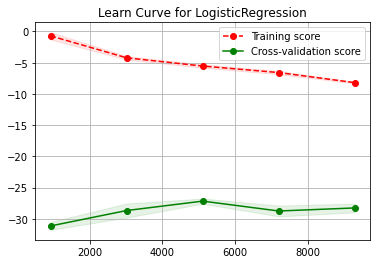

Function: evaluation_model Total Time Used: 29.743643045425415


In [232]:
m.evaluation_model(m.train_logistic(train=True))

In [ ]:
m.evaluation_model(m.train_random_forest(train=True))

DecisionTreeRegressor: Score - 0.7252447118795533
Function: train_decision_tree Total Time Used: 0.37878894805908203


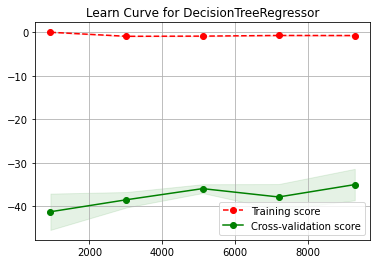

Function: evaluation_model Total Time Used: 3.1856729984283447


In [237]:
td = m.train_decision_tree(train=True)
m.evaluation_model(td)

Function: train_svm Total Time Used: 0.001199960708618164


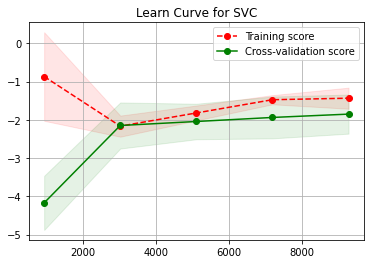

In [87]:
m.evaluation_model(m.train_svm(train=1))

Iteration 1, loss = 15.26902285
Validation score: 0.166732
Iteration 2, loss = 10.42123743
Validation score: 0.349705
Iteration 3, loss = 8.92170598
Validation score: 0.420677
Iteration 4, loss = 8.29822839
Validation score: 0.446708
Iteration 5, loss = 7.92928400
Validation score: 0.463033
Iteration 6, loss = 7.64716735
Validation score: 0.478306
Iteration 7, loss = 7.35387320
Validation score: 0.494171
Iteration 8, loss = 7.05922458
Validation score: 0.512259
Iteration 9, loss = 6.74719079
Validation score: 0.529301
Iteration 10, loss = 6.42167271
Validation score: 0.546634
Iteration 11, loss = 6.08118470
Validation score: 0.560539
Iteration 12, loss = 5.74274524
Validation score: 0.586172
Iteration 13, loss = 5.39025481
Validation score: 0.606175
Iteration 14, loss = 5.04212447
Validation score: 0.628532
Iteration 15, loss = 4.70314772
Validation score: 0.647280
Iteration 16, loss = 4.37232668
Validation score: 0.662127
Iteration 17, loss = 4.09424414
Validation score: 0.684048
Iter

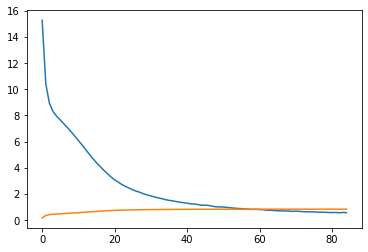

Function: train_mlp Total Time Used: 6.929973125457764
Iteration 1, loss = 20.87537724
Validation score: -0.496209
Iteration 2, loss = 17.14470608
Validation score: -0.224102
Iteration 3, loss = 14.19246302
Validation score: -0.038969
Iteration 4, loss = 12.10812352
Validation score: 0.048771
Iteration 5, loss = 10.95870359
Validation score: 0.073412
Iteration 6, loss = 10.57355035
Validation score: 0.089097
Iteration 7, loss = 10.12567367
Validation score: 0.140340
Iteration 8, loss = 9.54289781
Validation score: 0.205921
Iteration 9, loss = 8.96403774
Validation score: 0.262021
Iteration 10, loss = 8.45198857
Validation score: 0.306277
Iteration 11, loss = 8.00208363
Validation score: 0.344471
Iteration 12, loss = 7.62709820
Validation score: 0.378324
Iteration 13, loss = 7.26094187
Validation score: 0.408377
Iteration 14, loss = 6.90347846
Validation score: 0.435116
Iteration 15, loss = 6.54883608
Validation score: 0.459272
Iteration 16, loss = 6.23207792
Validation score: 0.484519


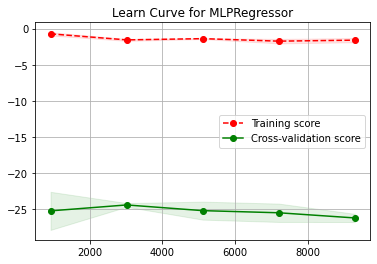

Function: evaluation_model Total Time Used: 42.909367084503174


In [239]:
mlp = m.train_mlp(train=1)
m.evaluation_model(mlp)

feature DLQ050_1.0 (0.152657)
feature SLQ050_2.0 (0.072254)
feature HSD010_5.0 (0.065797)
feature HSD010_4.0 (0.025406)
feature HUQ051_8 (0.018852)
feature OHQ870_0_2 (0.013241)
feature SXQ709_2.0 (0.013006)
feature SMQ040_1.0 (0.012199)
feature PFQ063D_10.0 (0.011978)
feature SLD010H_4_6 (0.011877)
feature MCQ300C_2.0 (0.011856)
feature HUQ010_4 (0.011747)
feature SXD031_NaN (0.011637)
feature PFQ063B_14.0 (0.011208)
feature SLD010H_6_8 (0.010957)
feature PFQ063A_10.0 (0.010740)
feature IND235_3.0 (0.010726)
feature PFQ063D_27.0 (0.010541)
feature RXDCOUNT_7_9 (0.009922)
feature ALQ130_NaN (0.009769)


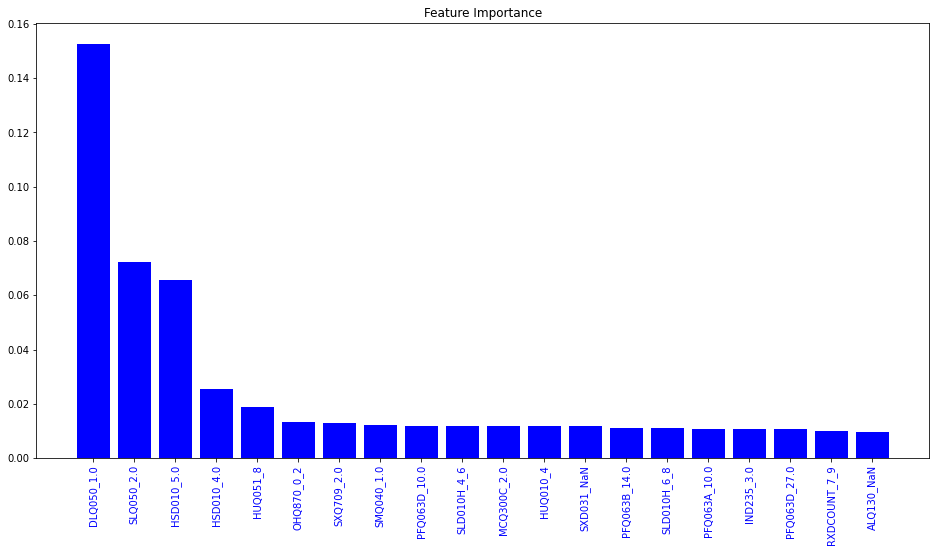

Function: feature_importance Total Time Used: 0.4570779800415039


In [238]:
m.feature_importance(td, showGraph=True)

In [ ]:
m.train_svm(train=True)

In [235]:
import imp
imp.reload(model)
imp.reload(health_data)
from model import Model

In [141]:
df_range_encoding.shape

(13934, 23051)